# 0.0 Imports

In [352]:
import pandas             as pd
import numpy              as np
import xgboost            as xgb
import scikitplot         as skplt

import matplotlib.pyplot  as plt
import seaborn            as sns

from IPython.display         import Image
from scipy                   import stats            as ss
from sklearn                 import preprocessing    as pp
from sklearn                 import model_selection  as ms
from sklearn                 import ensemble         as en
from sklearn                 import metrics          as m
from scikitplot              import metrics          as mt
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble     import RandomForestClassifier
from boruta               import BorutaPy
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors    import KNeighborsClassifier
from sklearn              import svm
from lightgbm             import LGBMClassifier
from sklearn.naive_bayes  import GaussianNB
from skopt                import forest_minimize
from skopt.plots          import plot_convergence
from flask                import Flask, request, Response
from imblearn.combine     import SMOTETomek

import warnings
import pickle
import inflection
warnings.filterwarnings("ignore")

%matplotlib inline

## 0.1 Helper Functions

In [353]:
def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_list = []
    mcc_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        
        # model precision
        precision = round(m.precision_score(y_val_fold, yhat_model),3)
        # recall
        recall = round(m.recall_score(y_val_fold, yhat_model),3)
        # model accuracy
        accuracy = round(m.accuracy_score(y_val_fold, yhat_model),3)
        # f1-score
        f1 = round(m.f1_score(y_val_fold, yhat_model),3)
        # mcc
        mcc = round(m.matthews_corrcoef(y_val_fold, yhat_model),3)
        #Roc_auc
        roc = round(m.roc_auc_score(y_val_fold,yhat_model),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        mcc_list.append(mcc)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    accuracy_str = np.round(np.mean(accuracy_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)    
    mcc_str = np.round(np.mean(mcc_list),4).astype(str) + ' +/- ' + np.round(np.std(mcc_list),4).astype(str)        
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, accuracy_str, f1_str, mcc_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance

## 0.2 Loading Data

In [354]:
data_kaggle = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_kaggle_block_fraud_company.csv')

In [355]:
data_kaggle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [356]:
data_kaggle['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

- Memory usage is too high (500MB+), there are many data to manipulate in a local machine. A split strategy will be applied to split data for less memory use

### 0.2.1 Data split 

In [357]:
data_kaggle_fraud = data_kaggle[data_kaggle['isFraud']==1]
data_kaggle_nonfraud = data_kaggle[data_kaggle['isFraud']==0].reset_index(drop=True)


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_1_index, train_2_index in split.split(data_kaggle_nonfraud, data_kaggle_nonfraud['type']):
    strat_train_1_set = data_kaggle_nonfraud.loc[train_1_index]
    strat_train_2_set = data_kaggle_nonfraud.loc[train_2_index]
    
strat_train_2_set = pd.concat([data_kaggle_fraud, strat_train_2_set], ignore_index=True)

In [358]:
strat_train_2_set.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv', index=False)
strat_train_2_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279095 entries, 0 to 1279094
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1279095 non-null  int64  
 1   type            1279095 non-null  object 
 2   amount          1279095 non-null  float64
 3   nameOrig        1279095 non-null  object 
 4   oldbalanceOrg   1279095 non-null  float64
 5   newbalanceOrig  1279095 non-null  float64
 6   nameDest        1279095 non-null  object 
 7   oldbalanceDest  1279095 non-null  float64
 8   newbalanceDest  1279095 non-null  float64
 9   isFraud         1279095 non-null  int64  
 10  isFlaggedFraud  1279095 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 107.3+ MB


- Now memory is 116 MB of usage, more acceptable to use in a local machine to manipulate data and process it.

In [359]:
strat_train_2_set['isFraud'].value_counts(normalize=True)

0    0.993579
1    0.006421
Name: isFraud, dtype: float64

### 0.2.1 Loading splited data

In [360]:
data_splited = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/dataset_sampled.csv')

#### 0.2.1.1 Slipt data in dataset (train and validation) and test

In [361]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for test_1_index, test_2_index in split.split(data_splited, data_splited['isFraud']):
    dataset = data_splited.loc[test_1_index]
    dataset_test = data_splited.loc[test_2_index]

In [362]:
dataset['isFraud'].value_counts(normalize=True)

0    0.993579
1    0.006421
Name: isFraud, dtype: float64

In [363]:
dataset_test['isFraud'].value_counts(normalize=True)

0    0.993577
1    0.006423
Name: isFraud, dtype: float64

# 1.0 Data Description

In [364]:
df1 = dataset.copy()

## 1.1 Rename Columns

In [365]:
cols_old = df1.columns
cols_old

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [366]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

In [367]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.2 Data Dimension

In [368]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1023276
Number of Columns: 11


## 1.3 Data Types

In [369]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

- It is not necessary to change data types.

## 1.4 Check NAN

In [370]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_org      0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

- There is no NAN in original datas

## 1.5 Fillout NA

- Not necessary, as seen in 1.4 section

## 1.6 Columns Description

In [371]:
cols = df1.columns
cols

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

- **step**: maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


- **type**: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.


- **amount**: amount of the transaction in local currency.


- **nameOrig**: customer who started the transaction


- **oldbalanceOrg**: initial balance before the transaction


- **newbalanceOrig**: new balance after the transaction


- **nameDest**: customer who is the recipient of the transaction


- **oldbalanceDest**: initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).


- **newbalanceDest**: new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).


- **isFraud**: This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.


- **isFlaggedFraud**: The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 1.7 Descriptive Statistical

In [372]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

In [373]:
num_attributes = df1[['step', 'amount', 'oldbalance_org', 'newbalance_orig','oldbalance_dest','newbalance_dest']]

cat_attributes = df1[['type', 'name_orig', 'name_dest', 'is_flagged_fraud' ]]

target_atribute = df1['is_fraud']

### 1.7.1 Numerical Attributes

In [374]:
# Central Tendency - Mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max()- x.min() ) ).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concatenate

m1 = pd.concat ([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,step,1.0,7.430000e+02,7.420000e+02,2.439527e+02,240.000,1.430546e+02,0.386756,0.341463
1,amount,0.0,7.117248e+07,7.117248e+07,1.861957e+05,75623.800,6.325517e+05,27.182822,1379.166333
2,oldbalance_org,0.0,5.958504e+07,5.958504e+07,8.371042e+05,14546.000,2.894599e+06,5.272977,33.500284
3,newbalance_orig,0.0,4.958504e+07,4.958504e+07,8.506715e+05,0.000,2.922455e+06,5.210857,32.548949
4,oldbalance_dest,0.0,3.023942e+08,3.023942e+08,1.097189e+06,129518.005,3.432465e+06,19.791516,863.865326
5,newbalance_dest,0.0,3.114049e+08,3.114049e+08,1.224265e+06,213112.805,3.713092e+06,19.295160,800.040367


### 1.7.2 Categorical Attributes

In [375]:
cat_attributes.apply(lambda x: x.unique().shape[0])

type                      5
name_orig           1023041
name_dest            659883
is_flagged_fraud          2
dtype: int64

<AxesSubplot:xlabel='type', ylabel='count'>

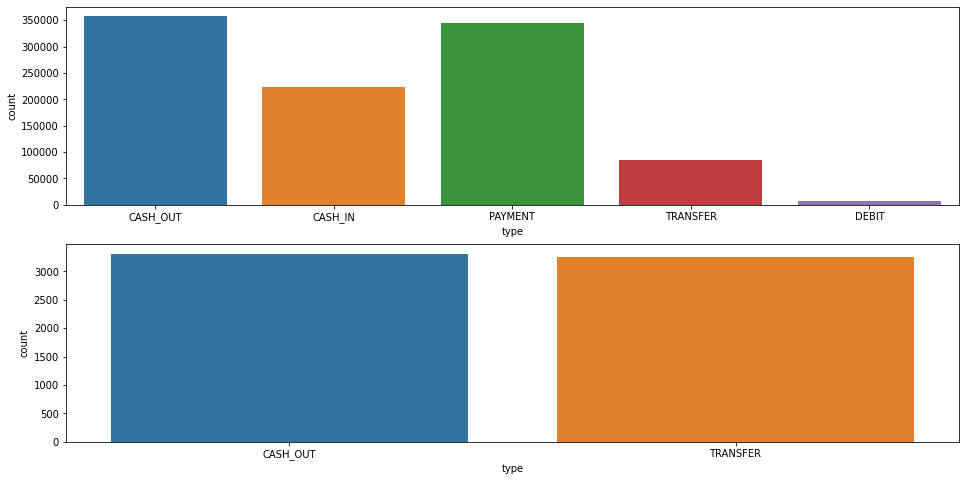

In [376]:
fig, axs = plt.subplots( nrows = 2,  figsize = (16,8))

sns.countplot(x ='type', data= df1[df1['is_fraud']==0], ax=axs[0])

sns.countplot(x ='type', data= df1[df1['is_fraud']==1], ax=axs[1])

In [377]:
df1[df1['is_fraud']==1]['name_orig'].value_counts()

C964573395     1
C1466532646    1
C1716255280    1
C927935901     1
C141049972     1
              ..
C767478867     1
C413256119     1
C379155103     1
C2015533974    1
C616239672     1
Name: name_orig, Length: 6570, dtype: int64

<AxesSubplot:xlabel='name_orig', ylabel='Density'>

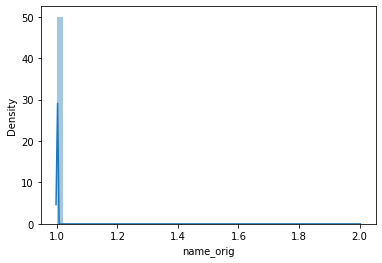

In [378]:
sns.distplot(cat_attributes['name_orig'].value_counts())

In [379]:
df1[df1['is_fraud']==1]['name_dest'].value_counts()

C1366192319    2
C475338087     2
C1837027614    2
C1980653895    2
C52390890      2
              ..
C156487696     1
C14537324      1
C125311108     1
C1470734212    1
C1418628619    1
Name: name_dest, Length: 6542, dtype: int64

<AxesSubplot:xlabel='name_dest'>

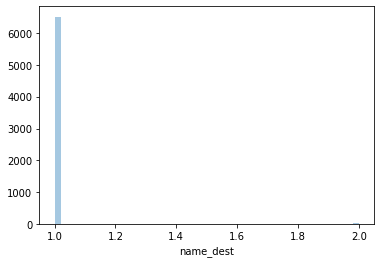

In [380]:
sns.distplot(df1[df1['is_fraud']==1]['name_dest'].value_counts(), kde = False)

In [381]:
target_atribute.value_counts(normalize=True)

0    0.993579
1    0.006421
Name: is_fraud, dtype: float64

**Data Description Summary:**

1. **XXX** 

## 1.8 Save dataset

In [382]:
df1.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/df1.csv', index=False)

# 2.0 Feature Engineering And Variables Filtering

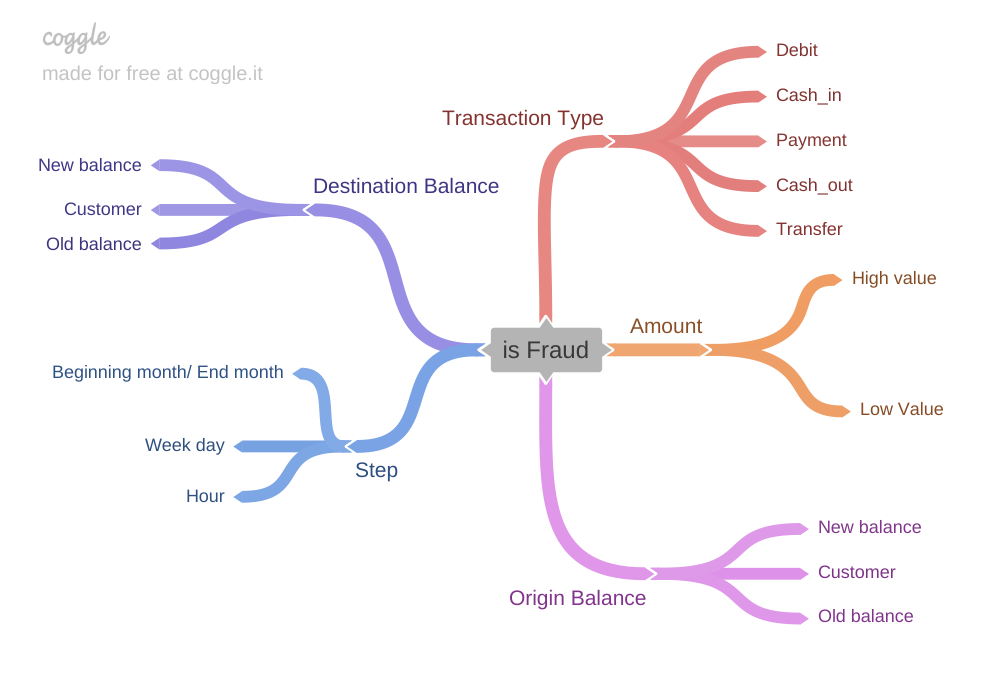

In [383]:
Image ('C:/Users/Guilherme/Repos/pa002_block_fraud_company/images/is_Fraud.png')

## 2.1 Hypotheses creation

### 2.1.1 Amount Hypotheses

 **1.** Fraud should occur in higher value amounts (higher than 200k)
 
 **2.** Fraud should occur in higher percent amount per origin balance (higher than 75%)
 
****

### 2.1.2 Transaction Type Hypotheses

 **1.** Fraud should occur in payment type of transaction
 
 **2.** Fraud should not occur in debit type of transaction
 
****

### 2.1.3 Origin Balance Hypotheses

 **1.** Fraud should occur when the difference between old balance and new balance is lower than amount
 
 **2.** Fraud should not occur when the difference between old balance and new balance is equal to amount
 
 **3.** Fraud should not occur when new balance is equal to 0
 
****

### 2.1.4 Destination Balance Hypotheses

 **1.** Fraud should occur when the difference between new balance and old balance is lower than amount
 
 **2.** Fraud should not occur when the difference between new balance and old balance is equal to amount
 
 **3.** Fraud should not occur when destination is merchant
 
 **4.** Fraud should occur with destination that receive with more frequency
 
****

### 2.1.5 Step Hypotheses

 **1.** Fraud should occur in the beginning of the month (day 1 to day 8)
 
 **2.** Fraud should occurs in weekends
 
 **3.** Fraud should occurs during night (6pm to 10pm)
 
****

## 2.2 Creating New Features

In [384]:
df2 = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/df1.csv')

In [385]:
#step features
#hour
df2['hour'] = df2['step'].apply( lambda x: x % 24 )
#day
df2['day'] = df2['step'].apply( lambda x: np.ceil(x / 24) )


#difference between old and new balance origin
df2['diff_orig'] = df2['oldbalance_org'] - df2['newbalance_orig']

#difference between new and old balance destination
df2['diff_dest'] = df2['newbalance_dest'] - df2['oldbalance_dest']

#merchant destination flag
df2['merchant_dest'] = df2.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

## 2.3 Variable Filtering

<AxesSubplot:xlabel='newbalance_dest'>

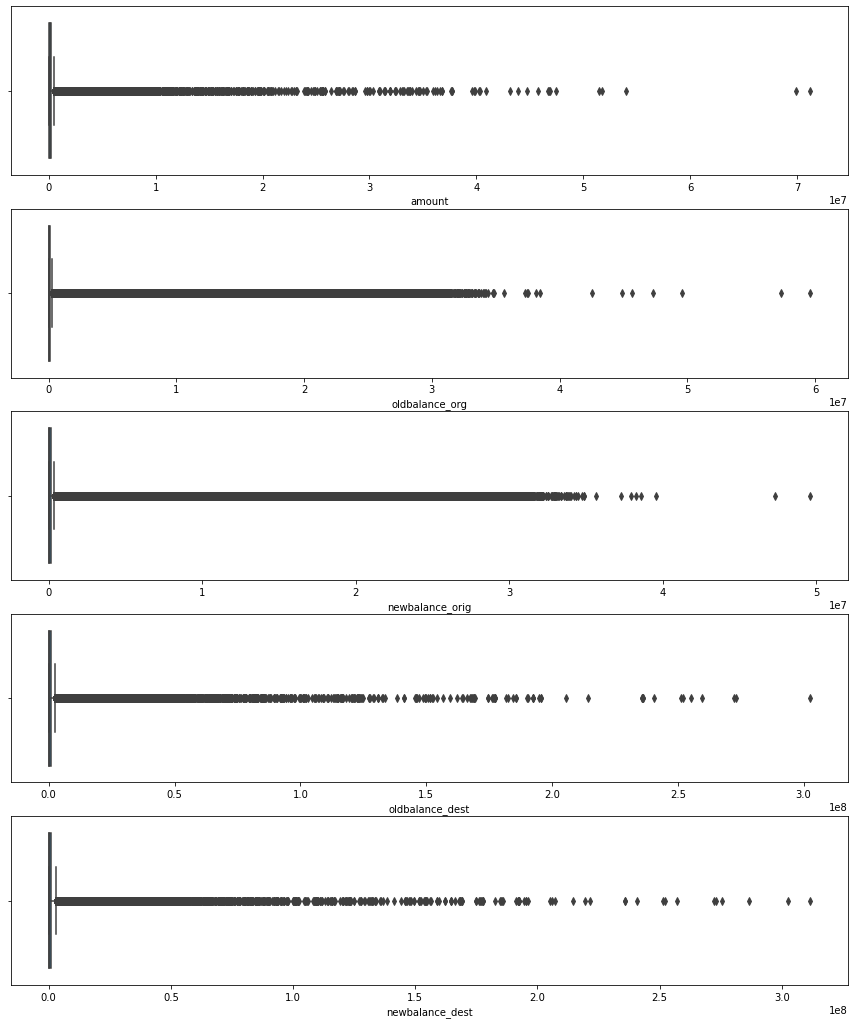

In [386]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

In [387]:
df2 = df2[df2['amount'] < 1e7]
df2 = df2[df2['oldbalance_org'] < 2e7]
df2 = df2[df2['newbalance_orig'] < 2e7]
df2 = df2[df2['oldbalance_dest'] < 5e7]
df2 = df2[df2['newbalance_dest'] < 5e8]

In [388]:
df2 = df2.reset_index(drop=True)

<AxesSubplot:xlabel='newbalance_dest'>

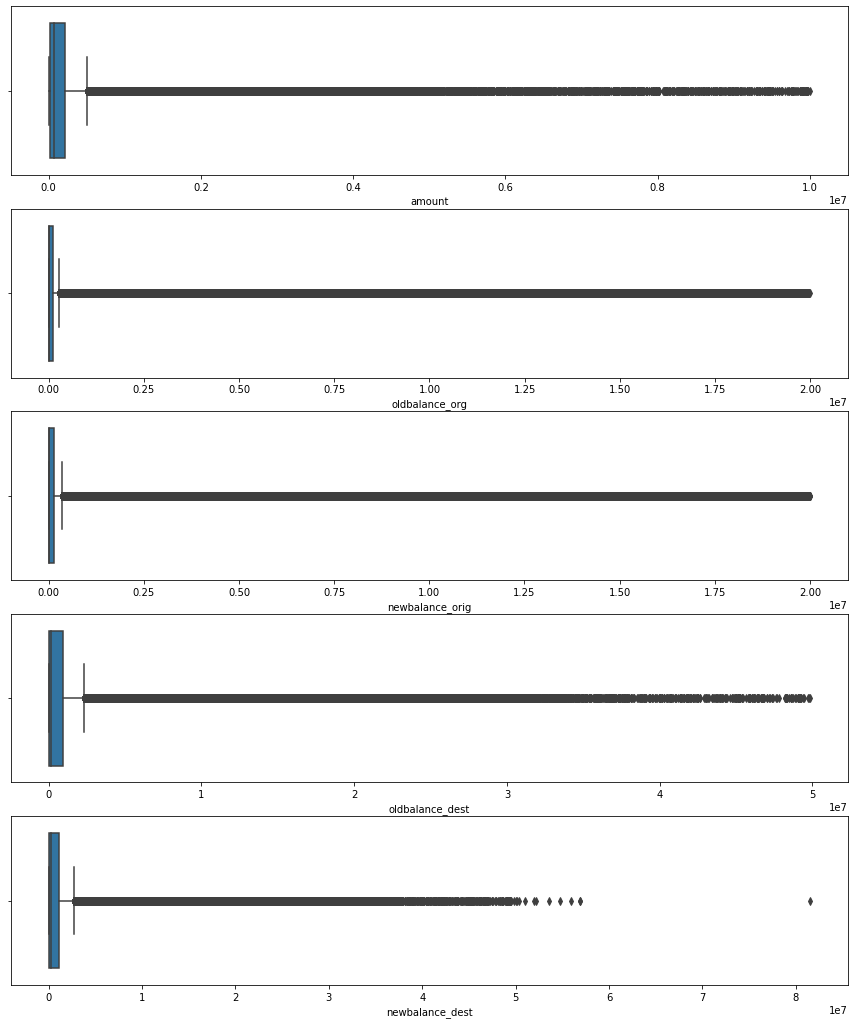

In [389]:
fig, axs = plt.subplots(nrows = 5, figsize = (15,18))
sns.boxplot(df2['amount'], ax=axs[0])
sns.boxplot(df2['oldbalance_org'], ax=axs[1])
sns.boxplot(df2['newbalance_orig'], ax=axs[2])
sns.boxplot(df2['oldbalance_dest'], ax=axs[3])
sns.boxplot(df2['newbalance_dest'], ax=axs[4])

## 2.4 Save dataset

In [390]:
df2.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/df2.csv', index=False)

# 3.0 Exploratory Data Analysis (EDA)

In [391]:
df3 = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/df2.csv')

## 3.1 Univariate Analysis

In [392]:
df3.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'hour', 'day', 'diff_orig', 'diff_dest',
       'merchant_dest'],
      dtype='object')

### 3.1.1 Numerical variables

#### 3.1.1.1 Step analysis

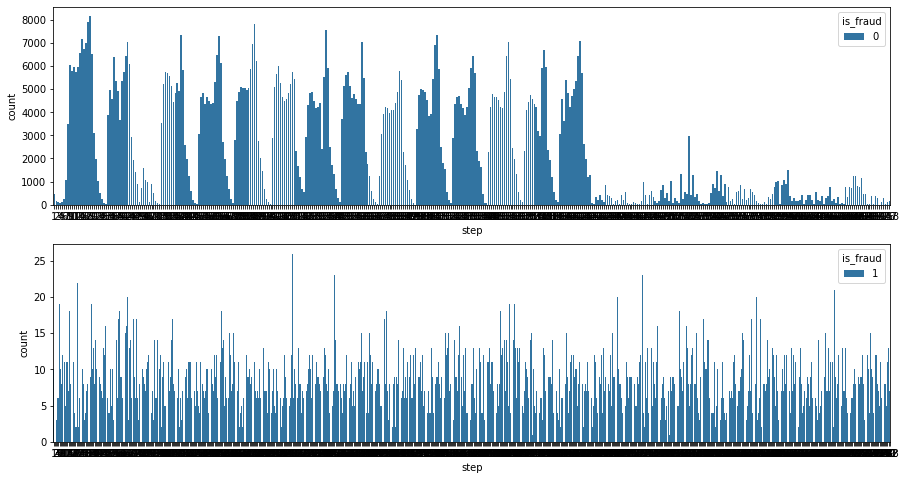

In [393]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'step', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'step', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

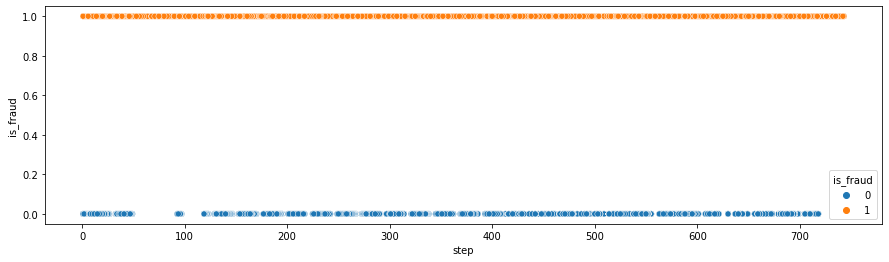

In [394]:
fig = plt.subplots( figsize = (15,4))
sns.scatterplot(x = 'step', data=df3, y='is_fraud', hue = 'is_fraud');

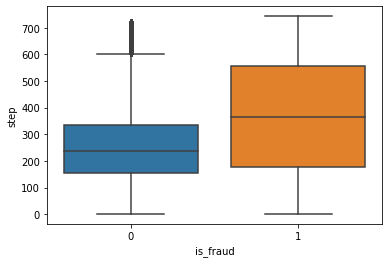

In [395]:
sns.boxplot(x= 'is_fraud', y='step', data=df3);

#### 3.1.1.2 Day analysis

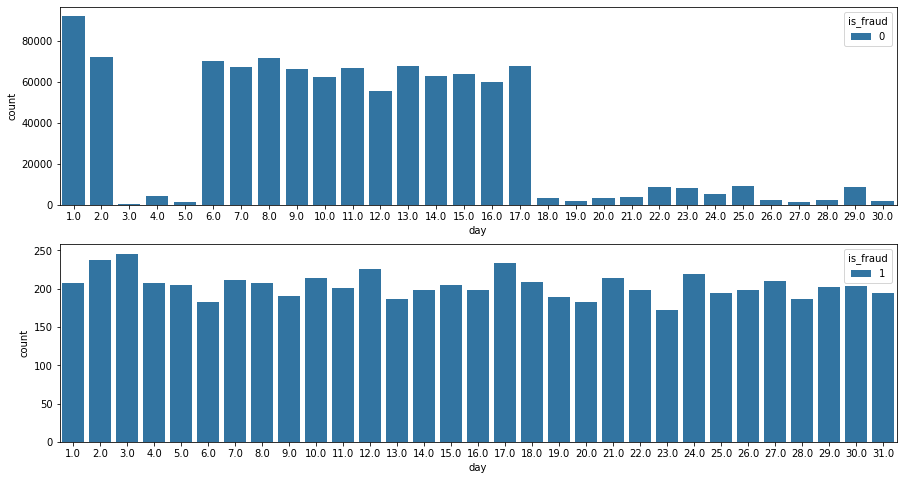

In [396]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'day', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'day', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

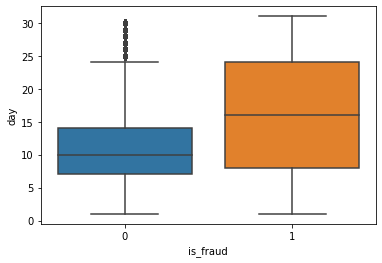

In [397]:
sns.boxplot(x= 'is_fraud', y='day', data=df3);

#### 3.1.1.3 Hour analysis

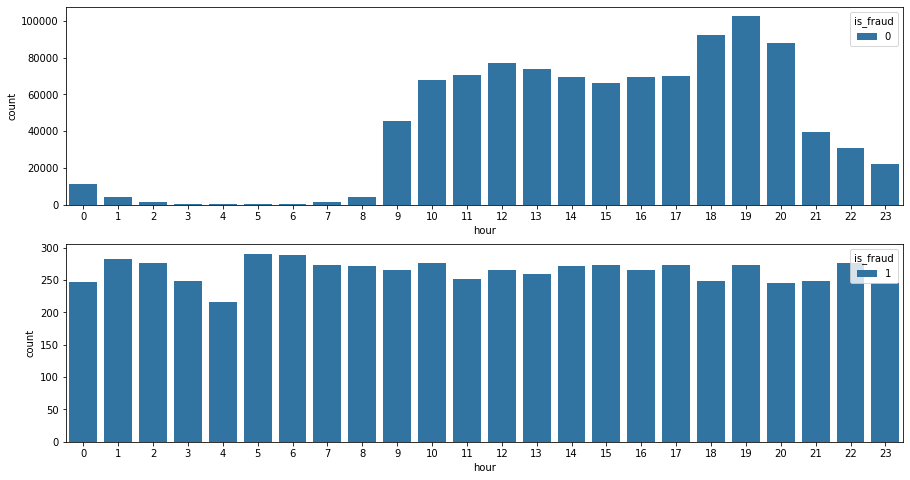

In [398]:
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'hour', data=df3[df3['is_fraud']==0], hue='is_fraud',ax=axs[0]);
sns.countplot(x = 'hour', data=df3[df3['is_fraud']==1], hue='is_fraud',ax=axs[1]);

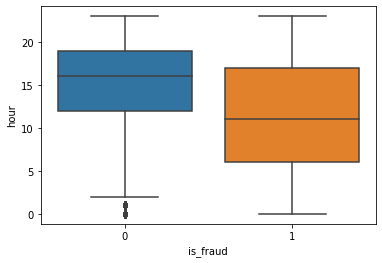

In [399]:
sns.boxplot(x= 'is_fraud', y='hour', data=df3);

#### 3.1.1.4 Amount analysis

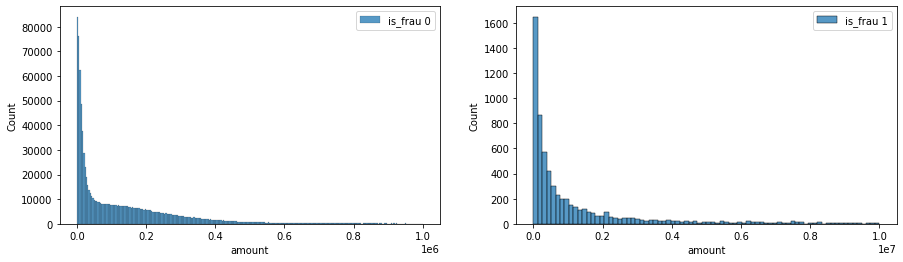

In [400]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['amount']< 1e6)]['amount'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[df3['is_fraud']== 1]['amount'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

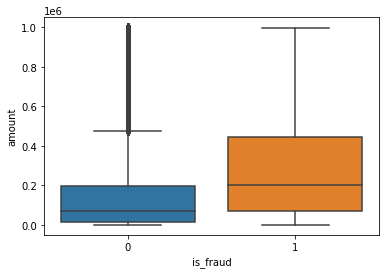

In [401]:
sns.boxplot(x= 'is_fraud', y='amount', data=df3[df3['amount']< 1e6]);

#### 3.1.1.5 Old balance origin analysis

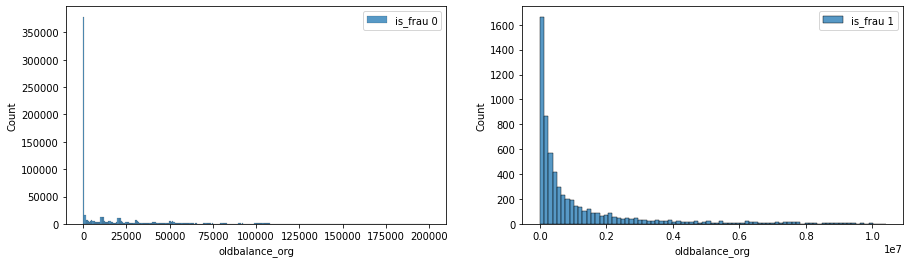

In [402]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['oldbalance_org']< 2e5)]['oldbalance_org'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['oldbalance_org']< 2e7)]['oldbalance_org'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

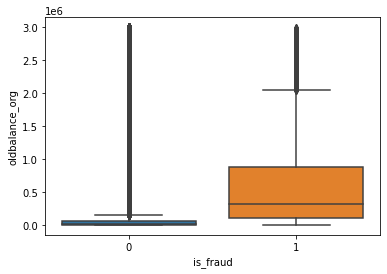

In [403]:
sns.boxplot(x= 'is_fraud', y='oldbalance_org', data=df3[df3['oldbalance_org']< 3e6]);

#### 3.1.1.6 New balance origin analysis

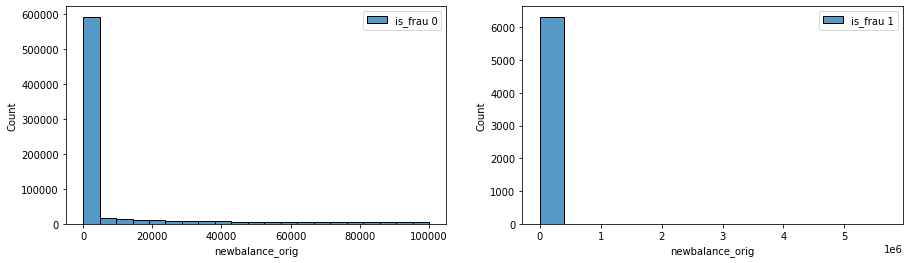

In [404]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['newbalance_orig']< 1e5)]['newbalance_orig'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['newbalance_orig']< 1e7)]['newbalance_orig'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

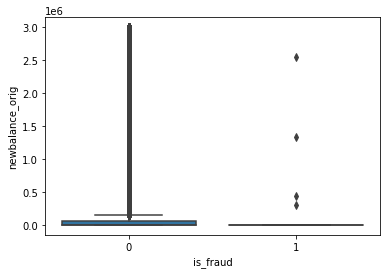

In [405]:
sns.boxplot(x= 'is_fraud', y='newbalance_orig', data=df3[df3['newbalance_orig']< 3e6]);

#### 3.1.1.7 Difference balance origin analysis

<AxesSubplot:xlabel='day', ylabel='diff_orig'>

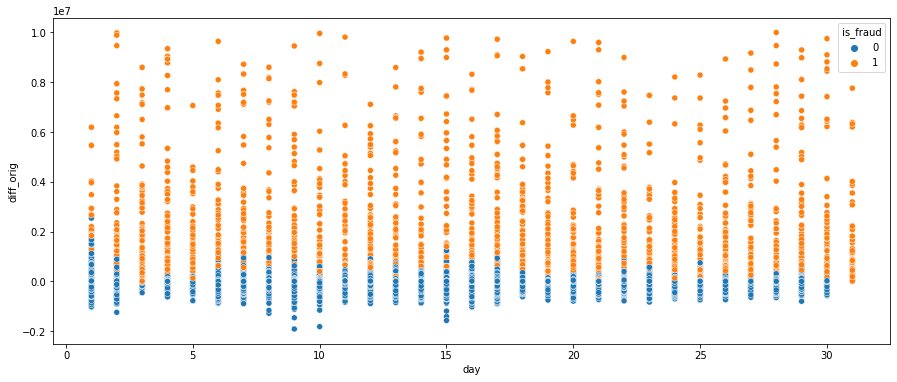

In [406]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='day', y='diff_orig', hue='is_fraud', data=df3)

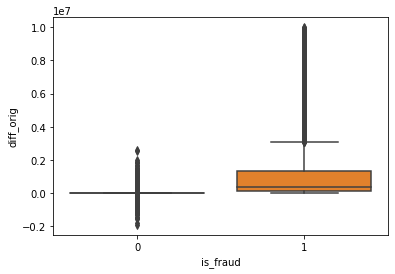

In [407]:
sns.boxplot(x= 'is_fraud', y='diff_orig', data=df3);

#### 3.1.1.8 Old balance destination analysis

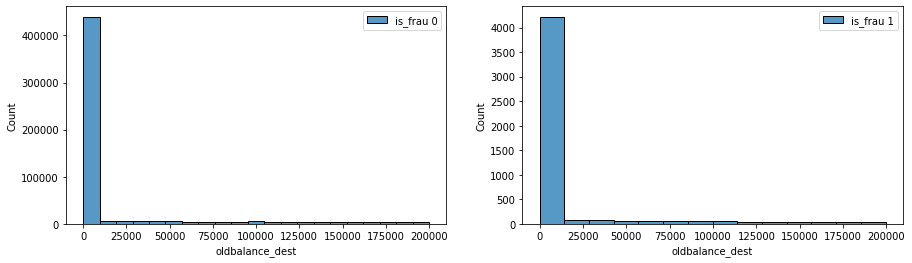

In [408]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['oldbalance_dest']< 2e5)]['oldbalance_dest'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['oldbalance_dest']< 2e5)]['oldbalance_dest'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

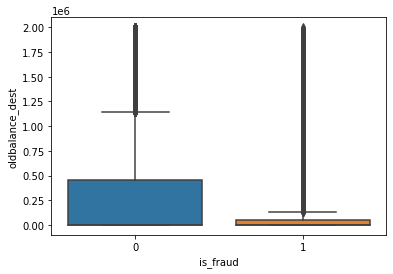

In [409]:
sns.boxplot(x= 'is_fraud', y='oldbalance_dest', data=df3[df3['oldbalance_dest']< 2e6]);

#### 3.1.1.9 New balance destination analysis

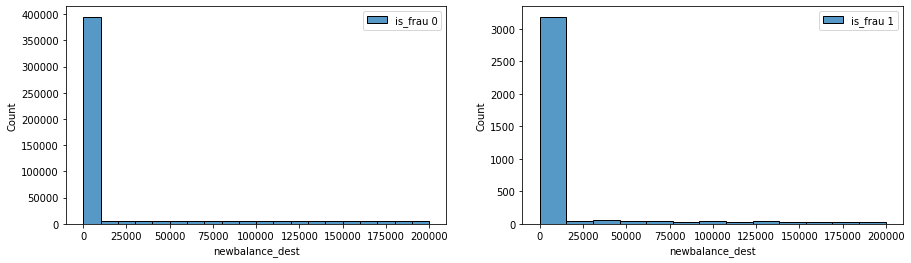

In [410]:
fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.histplot(df3[(df3['is_fraud']== 0) & (df3['newbalance_dest']< 2e5)]['newbalance_dest'], kde=False, label='reponse 0', ax=axs[0])
axs[0].legend(labels=['is_frau 0'])
sns.histplot(df3[(df3['is_fraud']== 1) & (df3['newbalance_dest']< 2e5)]['newbalance_dest'], kde=False, label='reponse 1', ax=axs[1])
axs[1].legend(labels=['is_frau 1'])

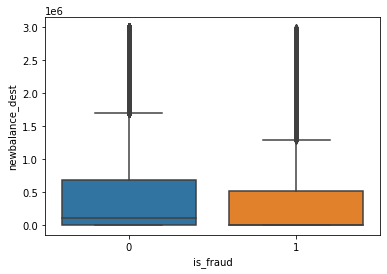

In [411]:
sns.boxplot(x= 'is_fraud', y='newbalance_dest', data=df3[df3['newbalance_dest']< 3e6]);

#### 3.1.1.10 Difference balance destination analysis

<AxesSubplot:xlabel='amount', ylabel='diff_dest'>

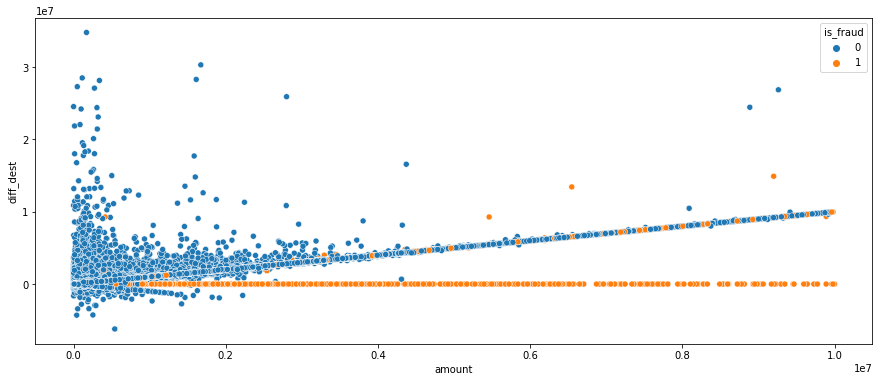

In [412]:
plt.subplots(figsize=(15,6))
sns.scatterplot(x='amount', y='diff_dest', hue='is_fraud', data=df3[(df3['amount']< 8e7) & (df3['diff_dest']< 4e7)])

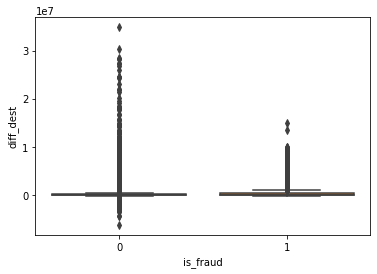

In [413]:
sns.boxplot(x= 'is_fraud', y='diff_dest', data=df3);

### 3.1.2 Categorical variables

#### 3.1.2.1 Transaction type analysis

<AxesSubplot:xlabel='type', ylabel='count'>

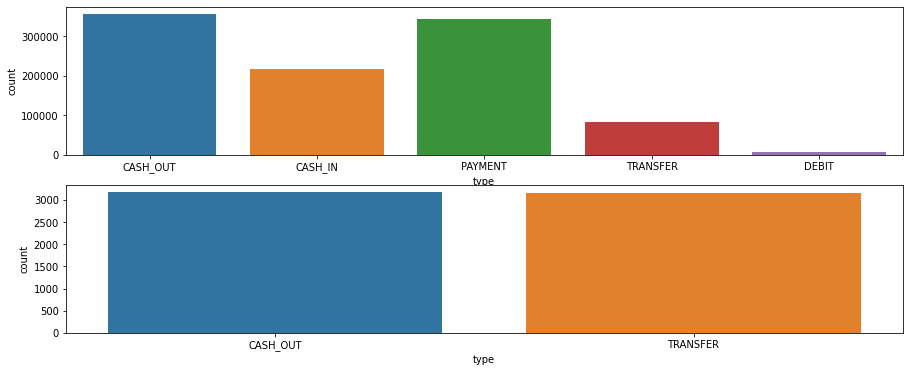

In [414]:
fig, axs = plt.subplots( nrows = 2,  figsize = (15,6))
sns.countplot(x ='type', data= df3[df3['is_fraud']==0], ax=axs[0])
sns.countplot(x ='type', data= df3[df3['is_fraud']==1], ax=axs[1])

<AxesSubplot:xlabel='amount', ylabel='diff_orig'>

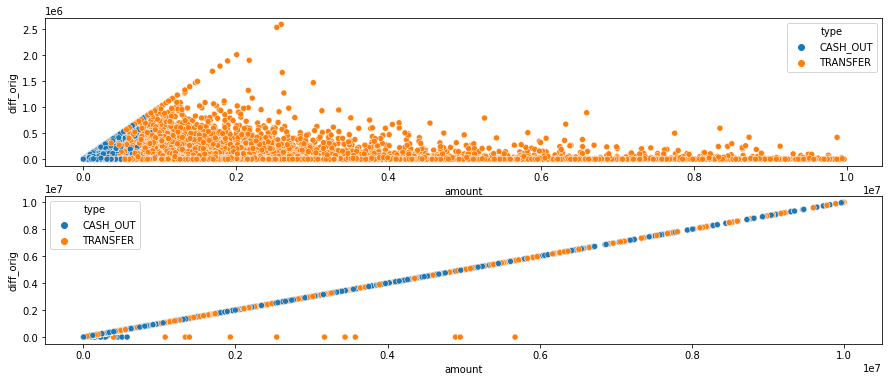

In [415]:
aux1 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER')) & (df3['is_fraud']==0)]
aux2 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER')) & (df3['is_fraud']==1)]
fig, axs = plt.subplots( nrows = 2,  figsize = (15,6))
sns.scatterplot(x='amount', y='diff_orig', hue='type', data=aux1, ax=axs[0])
sns.scatterplot(x='amount', y='diff_orig', hue='type', data=aux2, ax=axs[1])

<AxesSubplot:xlabel='amount', ylabel='diff_orig'>

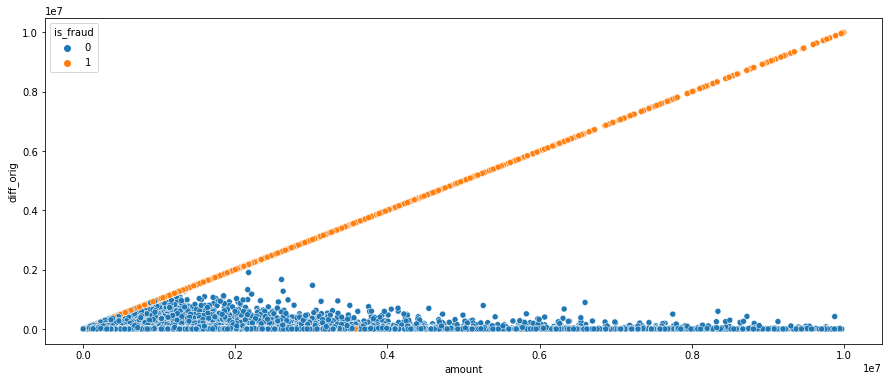

In [416]:
fig = plt.subplots( figsize = (15,6))
aux3 = df3[((df3['type']=='CASH_OUT') | (df3['type']=='TRANSFER'))]
sns.scatterplot(x='amount', y='diff_orig', hue='is_fraud', data=aux3)

#### 3.1.2.2 Name origin analysis

In [417]:
df3[df3['is_fraud']==1]['name_orig'].value_counts()

C964573395     1
C97010398      1
C1716255280    1
C927935901     1
C141049972     1
              ..
C1019916893    1
C1355391463    1
C1961162790    1
C864985630     1
C616239672     1
Name: name_orig, Length: 6334, dtype: int64

In [418]:
df3[df3['is_fraud']==0]['name_orig'].value_counts()

C513767625     2
C386261723     2
C1261941320    2
C2132910925    2
C519269284     2
              ..
C1124506123    1
C1338175678    1
C1824408610    1
C1312701487    1
C905727887     1
Name: name_orig, Length: 1009262, dtype: int64

#### 3.1.2.3 Name destination analysis

In [419]:
df3[df3['is_fraud']==1]['name_dest'].value_counts()

C964377943     2
C1837027614    2
C1655359478    2
C1653587362    2
C644163395     2
              ..
C1180460308    1
C1501386709    1
C1424612838    1
C1094429579    1
C1418628619    1
Name: name_dest, Length: 6307, dtype: int64

In [420]:
df3[(df3['is_fraud']==1)&(df3['name_dest'].str.startswith('M'))]['name_dest'].value_counts()

Series([], Name: name_dest, dtype: int64)

In [421]:
df3[df3['is_fraud']==0]['name_dest'].value_counts()

C665576141     21
C1360767589    20
C453211571     19
C1220897602    19
C1254526270    18
               ..
M1016569360     1
M345282459      1
C578313275      1
M237212122      1
C2085350675     1
Name: name_dest, Length: 654838, dtype: int64

In [422]:
df3[(df3['is_fraud']==0)&(df3['name_dest'].str.startswith('M'))]['name_dest'].value_counts()

M166132563     2
M2033938370    2
M1313761999    2
M2097695695    2
M1627810480    2
              ..
M1022347308    1
M301925110     1
M277430206     1
M1376642096    1
M1748551035    1
Name: name_dest, Length: 344302, dtype: int64

#### 3.1.2.4 Is flagged fraud analysis

In [423]:
df3['is_flagged_fraud'].value_counts()

0    1015815
1          9
Name: is_flagged_fraud, dtype: int64

#### 3.1.2.5 Merchant destination analysis

<AxesSubplot:xlabel='merchant_dest', ylabel='count'>

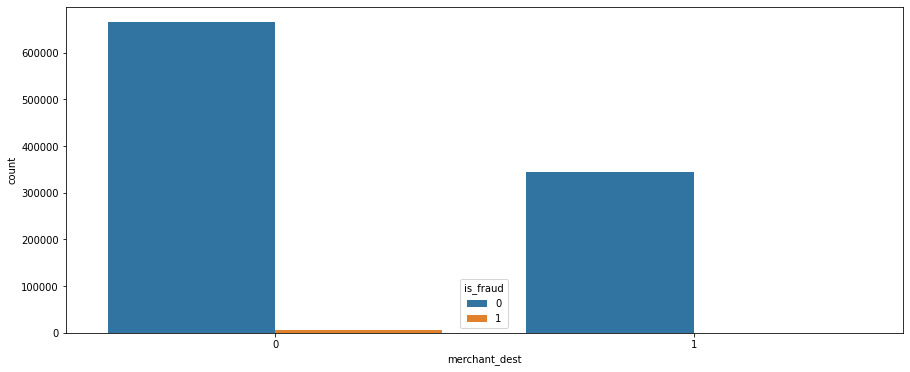

In [424]:
fig = plt.subplots(  figsize = (15,6))
sns.countplot(x ='merchant_dest', data= df3, hue = 'is_fraud')

In [425]:
df3['merchant_dest'].value_counts()

0    671489
1    344335
Name: merchant_dest, dtype: int64

In [426]:
df3[(df3['is_fraud']==0)]['merchant_dest'].value_counts()

0    665155
1    344335
Name: merchant_dest, dtype: int64

In [427]:
df3[(df3['is_fraud']==1)]['merchant_dest'].value_counts()

0    6334
Name: merchant_dest, dtype: int64

### 3.1.3 Target variable

<AxesSubplot:xlabel='is_fraud', ylabel='count'>

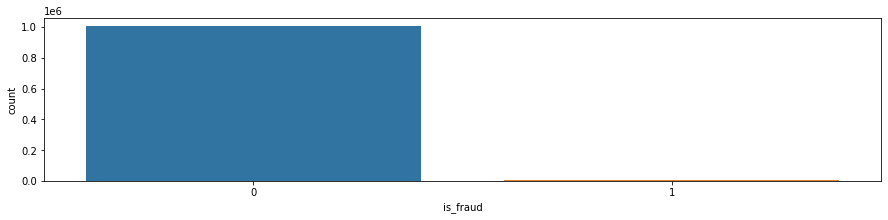

In [428]:
fig = plt.subplots(  figsize = (15,3))
sns.countplot(x ='is_fraud', data= df3)

In [429]:
df3['is_fraud'].value_counts()

0    1009490
1       6334
Name: is_fraud, dtype: int64

In [430]:
df3['is_fraud'].value_counts(normalize=True)

0    0.993765
1    0.006235
Name: is_fraud, dtype: float64

## 3.2 Bivariate Analysis

### 3.2.1 Fraud should occur in higher value amounts (higher than 200k)

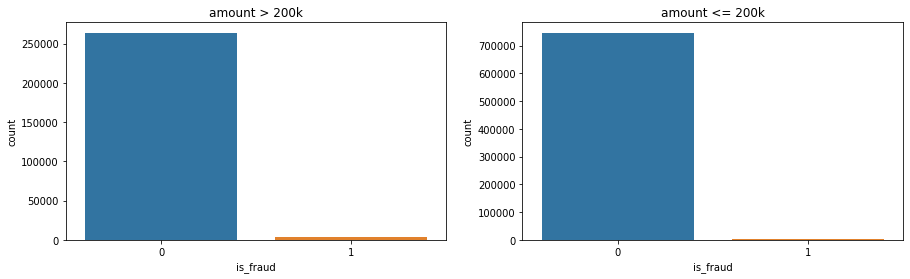

In [431]:
aux1 = df3[df3['amount']>2e5][['step','is_fraud']]
aux2 = df3[df3['amount']<=2e5][['step','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux1['is_fraud'], ax=axs[0]).set_title('amount > 200k')
sns.countplot(aux2['is_fraud'], ax=axs[1]).set_title('amount <= 200k');

In [432]:
aux1['is_fraud'].value_counts()

0    263734
1      4166
Name: is_fraud, dtype: int64

In [433]:
aux2['is_fraud'].value_counts()

0    745756
1      2168
Name: is_fraud, dtype: int64

In [434]:
aux3 = df3[['amount','is_fraud']]
aux3['amount_200'] = aux3['amount'].apply(lambda x: 1 if x > 2e5 else 0)
aux3 = pd.crosstab(aux3['amount_200'], aux3['is_fraud'])
aux3['percent %'] = aux3[1]*100/(aux3[1]+aux3[0])
aux3

is_fraud,0,1,percent %
amount_200,,,
0,745756,2168,0.289869
1,263734,4166,1.555058


Hypothesis **TRUE**
- 0.057% of amount <= 200k is a fraud transaction 
- 0.331% of amount > 200k is a fraud transaction 

### 3.2.2 Fraud should occur in higher percent amount per origin balance (higher than 75%)

In [435]:
aux4 = df3.copy()
aux4['amount_per_oldbalance_org'] = aux4['amount']/aux4['oldbalance_org']
aux4 = aux4[['amount_per_oldbalance_org', 'is_fraud', 'merchant_dest']]

aux4['amount_per_oldbalance_org_75%'] = aux4['amount_per_oldbalance_org'].apply(lambda x: 1 if x > 0.75 else 0)
aux4 = pd.crosstab(aux4['amount_per_oldbalance_org_75%'], aux4['is_fraud'])
aux4['percent %'] = aux4[1]*100/(aux4[1]+aux4[0])
aux4

is_fraud,0,1,percent %
amount_per_oldbalance_org_75%,,,
0,335764,14,0.004169
1,673726,6320,0.929349


Hypothesis **TRUE**
- 0.0056% of amount/oldbalance_org <= 0.75 is a fraud transaction 
- 0.192% of amount/oldbalance_org > 0.75 is a fraud transaction 

### 3.2.3 Fraud should occur in cash_out type of transaction

Text(0.5, 1.0, 'Cash_out')

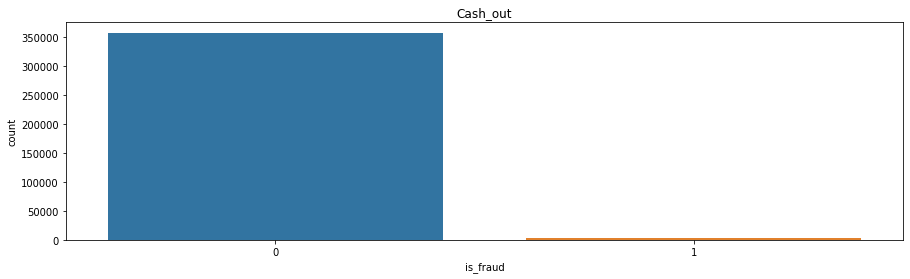

In [436]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(df3[df3['type']=='CASH_OUT']['is_fraud']).set_title('Cash_out')

In [437]:
df3[df3['type']=='CASH_OUT']['is_fraud'].value_counts()

0    357124
1      3187
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- there are 636 fraud's transactions in CASH_OUT type

### 3.2.4 Fraud should not occur in debit type of transaction

Text(0.5, 1.0, 'DEBIT')

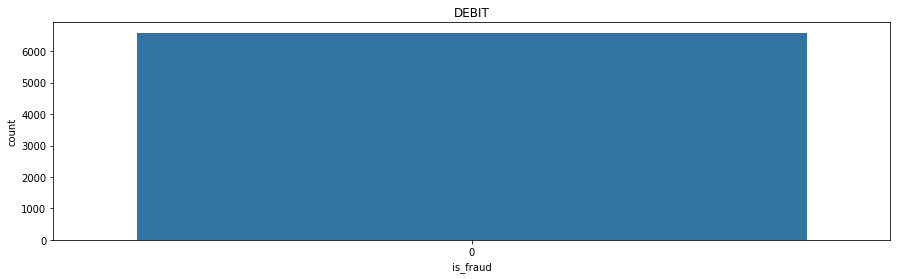

In [438]:
fig = plt.subplots(figsize = (15,4))
sns.countplot(df3[df3['type']=='DEBIT']['is_fraud']).set_title('DEBIT')

In [439]:
df3[df3['type']=='DEBIT']['is_fraud'].value_counts()

0    6582
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- there are not fraud's transaction in Debit type

### 3.2.5 Fraud should occur when the difference between old balance and new balance is lower than amount (origin)

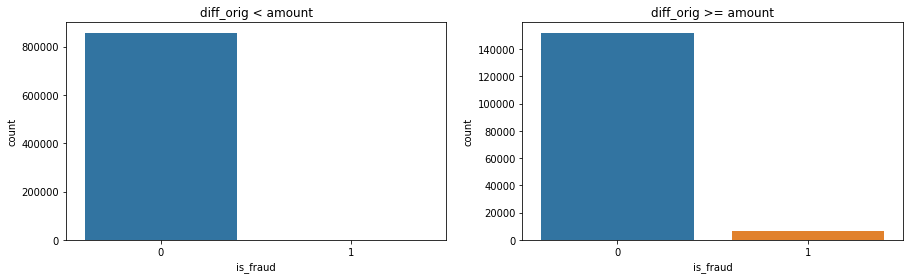

In [440]:
aux5 = df3.copy()
aux5['diff_orig_amount'] = aux5['diff_orig'] - aux5['amount']

aux6 = aux5[aux5['diff_orig_amount']<0][['diff_orig_amount','is_fraud']]
aux7 = aux5[aux5['diff_orig_amount']>=0][['diff_orig_amount','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux6['is_fraud'], ax=axs[0]).set_title('diff_orig < amount')
sns.countplot(aux7['is_fraud'], ax=axs[1]).set_title('diff_orig >= amount');

In [441]:
aux5['diff_orig_amount'] = aux5['diff_orig_amount'].apply(lambda x: 1 if x < 0 else 0)
aux5 = pd.crosstab(aux5['diff_orig_amount'], aux5['is_fraud'])
aux5['percent %'] = aux5[1]*100/(aux5[1]+aux5[0])
aux5

is_fraud,0,1,percent %
diff_orig_amount,,,
0,152080,6300,3.977775
1,857410,34,0.003965


Hypothesis **FALSE**
- 0.853% of diff_orig >= amount is a fraud transaction 
- 0.001% of diff_orig < amount is a fraud transaction 

### 3.2.6 Fraud should not occur when the difference between old balance and new balance is equal to amount (origin)

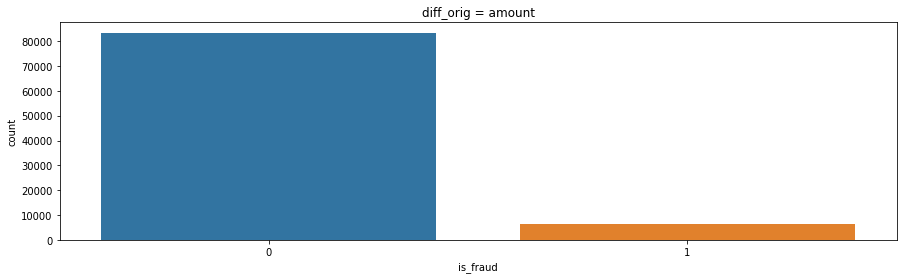

In [442]:
aux8 = df3.copy()
aux8['diff_orig_amount'] = aux8['diff_orig'] - aux8['amount']

aux8 = aux8[aux8['diff_orig_amount']==0][['diff_orig_amount','is_fraud']]

fig= plt.subplots( figsize = (15,4))
sns.countplot(aux8['is_fraud']).set_title('diff_orig = amount');

In [443]:
aux8['is_fraud'].value_counts()

0    83370
1     6298
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when difference between difference origin (newbalance - oldbalance) is equal to amount

### 3.2.7 Fraud should not occur when new balance is equal to 0 (origin)

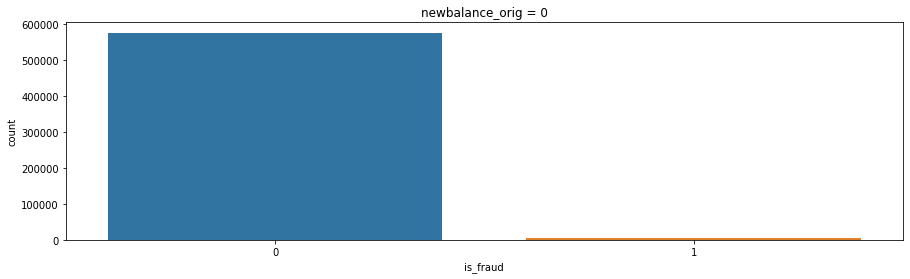

In [444]:
fig= plt.subplots( figsize = (15,4))
sns.countplot(df3[df3['newbalance_orig']==0]['is_fraud']).set_title('newbalance_orig = 0');

In [445]:
df3[df3['newbalance_orig']==0]['is_fraud'].value_counts()

0    575085
1      6323
Name: is_fraud, dtype: int64

In [446]:
df3[df3['newbalance_orig']!=0]['is_fraud'].value_counts()

0    434405
1        11
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when newbalance is equal to zero

### 3.2.8 Fraud should occur when the difference between new balance and old balance is lower than amount (destination)

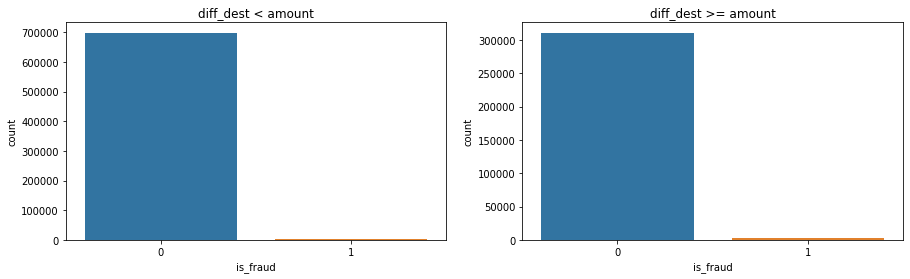

In [447]:
aux9 = df3.copy()
aux9['diff_dest_amount'] = aux9['diff_dest'] - aux9['amount']

aux10 = aux9[aux9['diff_dest_amount']<0][['diff_dest_amount','is_fraud']]
aux11 = aux9[aux9['diff_dest_amount']>=0][['diff_dest_amount','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux10['is_fraud'], ax=axs[0]).set_title('diff_dest < amount')
sns.countplot(aux11['is_fraud'], ax=axs[1]).set_title('diff_dest >= amount');

In [448]:
aux9['diff_dest_amount'] = aux9['diff_dest_amount'].apply(lambda x: 1 if x < 0 else 0)
aux9 = pd.crosstab(aux9['diff_dest_amount'], aux9['is_fraud'])
aux9['percent %'] = aux9[1]*100/(aux9[1]+aux9[0])
aux9

is_fraud,0,1,percent %
diff_dest_amount,,,
0,310873,2544,0.811698
1,698617,3790,0.539573


Hypothesis **TRUE**
- 0.161% of diff_dest < amount is a fraud transaction 
- 0.115% of diff_dest >= amount is a fraud transaction 

### 3.2.9 Fraud should not occur when the difference between new balance and old balance is equal to amount (destination)

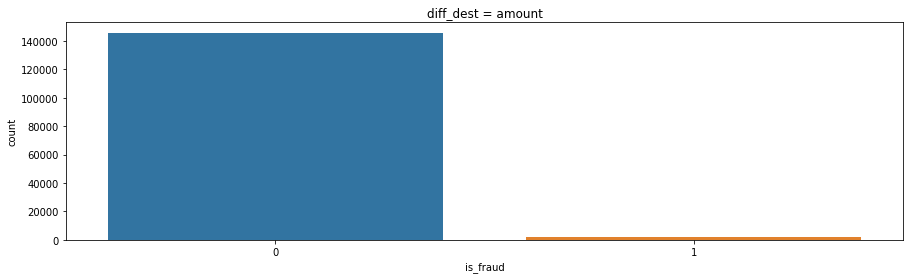

In [449]:
fig = plt.subplots(figsize = (15,4))

sns.countplot(aux11[aux11['diff_dest_amount']==0]['is_fraud']).set_title('diff_dest = amount');

In [450]:
aux11[aux11['diff_dest_amount']==0]['is_fraud'].value_counts()

0    145840
1      1831
Name: is_fraud, dtype: int64

Hypothesis **FALSE**
- Fraud occurs when the difference between new balance and old balance (destination) is equal to amount 

### 3.2.10 Fraud should not occur when destination is merchant (destination)

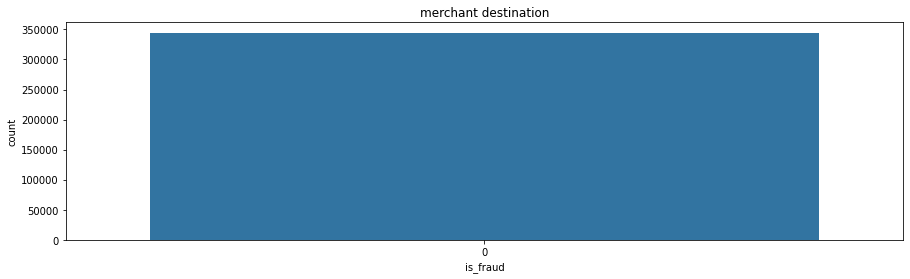

In [451]:
fig = plt.subplots(figsize = (15,4))

sns.countplot(df3[df3['merchant_dest']==1]['is_fraud']).set_title('merchant destination');

In [452]:
df3[df3['merchant_dest']==1]['is_fraud'].value_counts()

0    344335
Name: is_fraud, dtype: int64

Hypothesis **TRUE**
- Fraud does not occur when destination is merchant (destination)

### 3.2.11 Fraud should occur in the beginning of the month (day 1 to day 8)

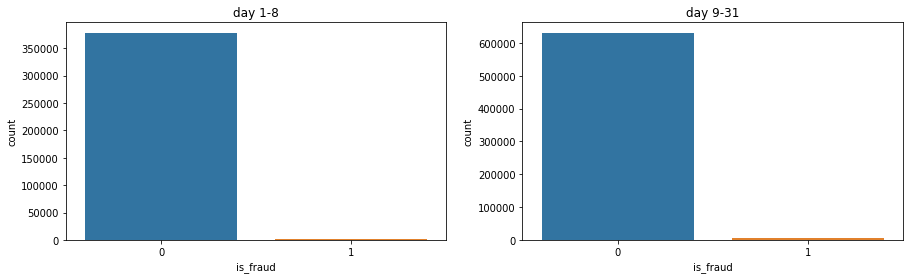

In [453]:
aux12 = df3[df3['day']<9][['day','is_fraud']]
aux13 = df3[df3['day']>=9][['day','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux12['is_fraud'], ax=axs[0]).set_title('day 1-8')
sns.countplot(aux13['is_fraud'], ax=axs[1]).set_title('day 9-31');

In [454]:
aux14 = df3.copy()
aux14['day_beginning'] = aux14['day'].apply(lambda x: 1 if x < 9 else 0)
aux14 = pd.crosstab(aux14['day_beginning'], aux14['is_fraud'])
aux14['percent %'] = aux14[1]*100/(aux14[1]+aux14[0])
aux14

is_fraud,0,1,percent %
day_beginning,,,
0,631152,4629,0.728081
1,378338,1705,0.448633


Hypothesis **TRUE**
- 0.15% is fraud of day 1 to day 8
- 0.09% is fraud of day 9 to day 31

### 3.2.12 Fraud should occurs during night (6pm to 11h59 pm)

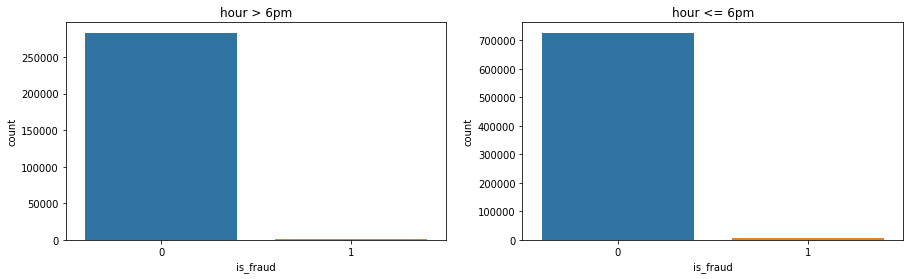

In [455]:
aux15 = df3[df3['hour']>18][['hour','is_fraud']]
aux16 = df3[df3['hour']<=18][['hour','is_fraud']]

fig, axs = plt.subplots(ncols= 2, figsize = (15,4))
sns.countplot(aux15['is_fraud'], ax=axs[0]).set_title('hour > 6pm')
sns.countplot(aux16['is_fraud'], ax=axs[1]).set_title('hour <= 6pm');

In [456]:
aux17 = df3.copy()
aux17['hour_night'] = aux17['hour'].apply(lambda x: 1 if x > 18 else 0)
aux17 = pd.crosstab(aux17['hour_night'], aux17['is_fraud'])
aux17['percent %'] = aux17[1]*100/(aux17[1]+aux17[0])
aux17

is_fraud,0,1,percent %
hour_night,,,
0,726340,5045,0.689787
1,283150,1289,0.453173


Hypothesis **FALSE**
- 0.14% is fraud of hour 6pm to midnight
- 0.10% is fraud of hour midnight to 6 pm

## 3.3 Multivariable Analysis

### 3.3.1 Numerical Attributes

In [457]:
df3.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_org      float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
hour                  int64
day                 float64
diff_orig           float64
diff_dest           float64
merchant_dest         int64
dtype: object

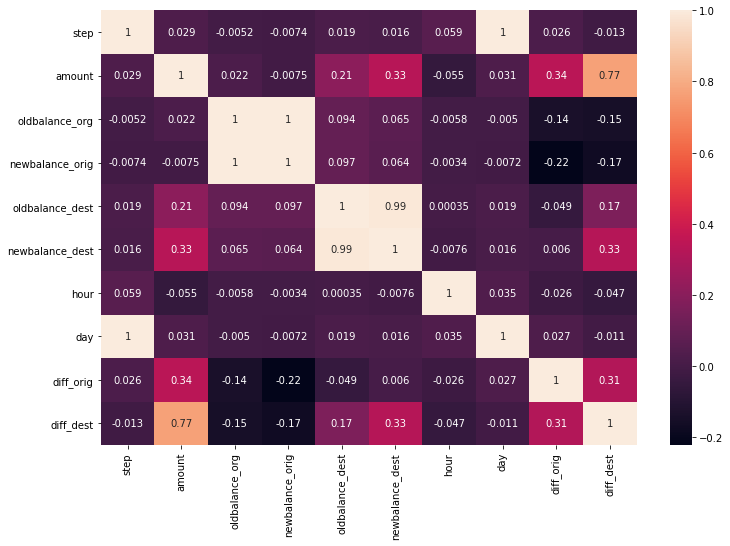

In [458]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])
num_attributes = num_attributes.drop(['merchant_dest','is_flagged_fraud','is_fraud'], axis=1)
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_attributes.corr(), annot = True);

## 3.4 Hypothesis conclusion 

In [459]:
hyp_conclu = pd.DataFrame(columns= ['Hypothesis', 'True/False', 'Relevance'])

hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H1 - Fraud should occur in higher value amounts (higher than 200k)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H2 - Fraud should occur in higher percent amount per origin balance (higher than 75%)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H3 - Fraud should occur in cash_out type of transaction', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H4 - Fraud should not occur in debit type of transaction', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H5 - Fraud should occur when the difference between old balance and new balance is lower than amount (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H6 - Fraud should not occur when the difference between old balance and new balance is equal to amount (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H7 - Fraud should not occur when new balance is equal to 0 (origin)', 'False', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H8 - Fraud should occur when the difference between new balance and old balance is lower than amount (destination)', 'False', 'Low'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H9 - Fraud should not occur when the difference between new balance and old balance is equal to amount (destination)', 'False', 'Mid'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H10 - Fraud should not occur when destination is merchant (destination)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H11 - Fraud should occur in the beginning of the month (day 1 to day 8)', 'True', 'High'])), ignore_index=True)
hyp_conclu = hyp_conclu.append(dict(zip(hyp_conclu.columns,['H12 - Fraud should occurs during night (6pm to 11h59 pm)', 'False', 'Mid'])), ignore_index=True)

pd.set_option('display.max_colwidth', 120)
hyp_conclu

,Hypothesis,True/False,Relevance
0,H1 - Fraud should occur in higher value amounts (higher than 200k),True,High
1,H2 - Fraud should occur in higher percent amount per origin balance (higher than 75%),True,High
2,H3 - Fraud should occur in cash_out type of transaction,True,High
3,H4 - Fraud should not occur in debit type of transaction,True,High
4,H5 - Fraud should occur when the difference between old balance and new balance is lower than amount (origin),False,High
5,H6 - Fraud should not occur when the difference between old balance and new balance is equal to amount (origin),False,High
6,H7 - Fraud should not occur when new balance is equal to 0 (origin),False,High
7,H8 - Fraud should occur when the difference between new balance and old balance is lower than amount (destination),False,Low
8,H9 - Fraud should not occur when the difference between new balance and old balance is equal to amount (destination),False,Mid
9,H10 - Fraud should not occur when destination is merchant (destination),True,High


# 4.0 Data Preparation

In [460]:
df3.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud', 'hour', 'day', 'diff_orig', 'diff_dest',
       'merchant_dest'],
      dtype='object')

<AxesSubplot:xlabel='diff_dest'>

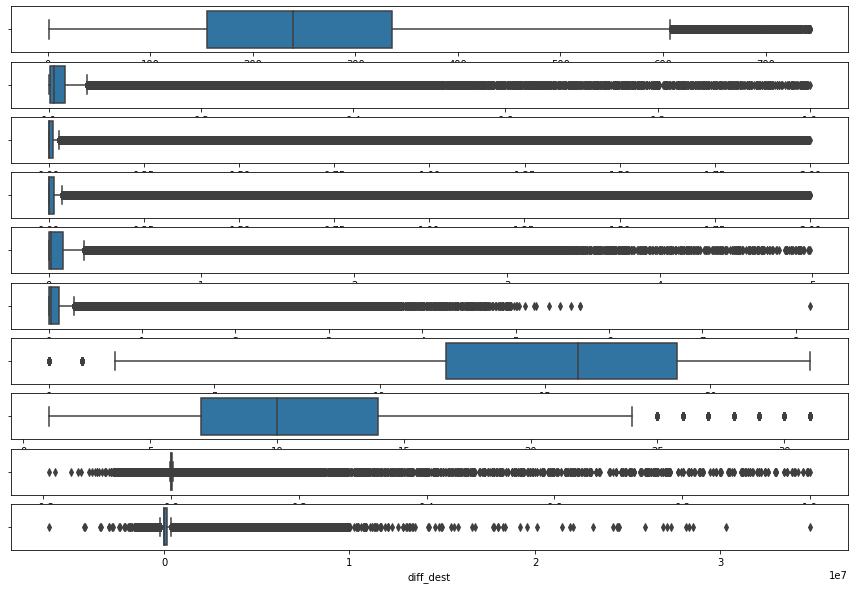

In [461]:
fig, axs = plt.subplots(nrows = 10, figsize = (15,10))
sns.boxplot(df3['step'], ax=axs[0])
sns.boxplot(df3['amount'], ax=axs[1])
sns.boxplot(df3['oldbalance_org'], ax=axs[2])
sns.boxplot(df3['newbalance_orig'], ax=axs[3])
sns.boxplot(df3['oldbalance_dest'], ax=axs[4])
sns.boxplot(df3['newbalance_dest'], ax=axs[5])
sns.boxplot(df3['hour'], ax=axs[6])
sns.boxplot(df3['day'], ax=axs[7])
sns.boxplot(df3['diff_orig'], ax=axs[8])
sns.boxplot(df3['diff_dest'], ax=axs[9])

## 4.1 Split data to train and validation data

In [462]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for val_1_index, val_2_index in split.split(df3, df3['is_fraud']):
    df4 = df3.loc[val_1_index]
    val = df3.loc[val_2_index]

In [463]:
df4['is_fraud'].value_counts(normalize=True)

0    0.993765
1    0.006235
Name: is_fraud, dtype: float64

In [464]:
val['is_fraud'].value_counts(normalize=True)

0    0.993765
1    0.006235
Name: is_fraud, dtype: float64

In [465]:
print('Number of Rows: {}'.format(df4.shape[0]))
print('Number of Columns: {}'.format(df4.shape[1]))

Number of Rows: 863450
Number of Columns: 16


In [466]:
print('Number of Rows: {}'.format(val.shape[0]))
print('Number of Columns: {}'.format(val.shape[1]))

Number of Rows: 152374
Number of Columns: 16


## 4.2 Rescaling

In [467]:
#step
mms_step = pp.MinMaxScaler()
df4['step'] = mms_step.fit_transform(df4[['step']].values)
pickle.dump (mms_step, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/mms_step_scaler.pkl', 'wb'))

#day
mms_day = pp.MinMaxScaler()
df4['day'] = mms_day.fit_transform(df4[['day']].values)
pickle.dump (mms_day, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/mms_day_scaler.pkl', 'wb'))

#amount
rbs_amount = pp.RobustScaler()
df4['amount'] = rbs_amount.fit_transform(df4[['amount']].values)
pickle.dump (rbs_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/rbs_amount_scaler.pkl', 'wb'))

#oldbalance_org
obo_amount = pp.RobustScaler()
df4['oldbalance_org'] = obo_amount.fit_transform(df4[['oldbalance_org']].values)
pickle.dump (obo_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/obo_amount_scaler.pkl', 'wb'))

#newbalance_orig 
nbo_amount = pp.RobustScaler()
df4['newbalance_orig'] = nbo_amount.fit_transform(df4[['newbalance_orig']].values)
pickle.dump (nbo_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/nbo_amount_scaler.pkl', 'wb'))

#oldbalance_dest
obd_amount = pp.RobustScaler()
df4['oldbalance_dest'] = obd_amount.fit_transform(df4[['oldbalance_dest']].values)
pickle.dump (obd_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/obd_amount_scaler.pkl', 'wb'))

#newbalance_dest
nbd_amount = pp.RobustScaler()
df4['newbalance_dest'] = nbd_amount.fit_transform(df4[['newbalance_dest']].values)
pickle.dump (nbd_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/nbd_amount_scaler.pkl', 'wb'))

#diff_orig
dfo_amount = pp.RobustScaler()
df4['diff_orig'] = dfo_amount.fit_transform(df4[['diff_orig']].values)
pickle.dump (dfo_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/dfo_amount_scaler.pkl', 'wb'))

#diff_dest
dfd_amount = pp.RobustScaler()
df4['diff_dest'] = dfd_amount.fit_transform(df4[['diff_dest']].values)
pickle.dump (dfd_amount, open('C:/Users/Guilherme/Repos/pa002_block_fraud_company/parameter/dfd_amount_scaler.pkl', 'wb'))


## 4.3 Transformation

### 4.3.1 Encoding

In [468]:
#type
df4 = pd.get_dummies(df4, prefix=['type'], columns=['type'])

### 4.3.1 Nature Transformation

In [469]:
#hour 
df4['hour_sen'] = df4['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
df4['hour_cos'] = df4['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
df4 = df4.drop('hour', axis = 1)

#day
#df2['day_sen'] = df2['step'].apply( lambda x: np.sin( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )
#df2['day_cos'] = df2['step'].apply( lambda x: np.cos( np.ceil(x / 24)  * (2. * np.pi/31 ) ) )

## 4.4 Validation preparation

In [470]:
#step
val['step'] = mms_step.transform(val[['step']].values)

#day
val['day'] = mms_day.transform(val[['day']].values)

#amount
val['amount'] = rbs_amount.transform(val[['amount']].values)

#oldbalance_org
val['oldbalance_org'] = obo_amount.transform(val[['oldbalance_org']].values)

#newbalance_orig 
val['newbalance_orig'] = nbo_amount.transform(val[['newbalance_orig']].values)

#oldbalance_dest
val['oldbalance_dest'] = obd_amount.transform(val[['oldbalance_dest']].values)

#newbalance_dest
val['newbalance_dest'] = nbd_amount.transform(val[['newbalance_dest']].values)

#diff_orig
val['diff_orig'] = dfo_amount.transform(val[['diff_orig']].values)

#diff_dest
val['diff_dest'] = dfd_amount.transform(val[['diff_dest']].values)

#type
val = pd.get_dummies(val, prefix=['type'], columns=['type'])

#hour 
val['hour_sen'] = val['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
val['hour_cos'] = val['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
val = val.drop('hour', axis = 1)

val = val.dropna(axis=1)

## 4.5 Save dataset

In [471]:
df4.to_csv('C:/Users/Guilherme/Repos/Dataset pa002/df4.csv', index=False)

# 5.0 Feature Selection

In [472]:
df5 = pd.read_csv('C:/Users/Guilherme/Repos/Dataset pa002/df4.csv')

## 5.1 Train preparation

In [473]:
#Removing columns
#is_flagged_fraud, 'name_orig', 'name_dest' wont be considered for train model

x_train = df5.drop(['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest'], axis =1)
y_train = df5['is_fraud'].copy()

## 5.2 Boruta

x_train_b = x_train.values
y_train_b = y_train.values.ravel()

rf = RandomForestClassifier( n_jobs=-1)
boruta = BorutaPy(rf,n_estimators='auto',verbose=0,random_state=77).fit(x_train_b,y_train_b)

cols_selected = boruta.support_.tolist()

#columns selected
x_train_fs=x_train
cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

#columns not selected
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))
print("BorutaSelected Column:")
cols_selected_boruta

## 5.2 Feature importance

In [474]:
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs=-1)

x_train_n = x_train
y_train_n = y_train
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
           feature  importance
0        diff_orig    0.273273
0        diff_dest    0.106491
0   oldbalance_org    0.099757
0           amount    0.088464
0  newbalance_dest    0.078553
0         hour_sen    0.064384
0              day    0.064228
0             step    0.061162
0         hour_cos    0.051968
0  oldbalance_dest    0.040665
0  newbalance_orig    0.027290
0    type_TRANSFER    0.019926
0    type_CASH_OUT    0.013199
0     type_CASH_IN    0.004722
0     type_PAYMENT    0.002736
0    merchant_dest    0.002658
0       type_DEBIT    0.000524


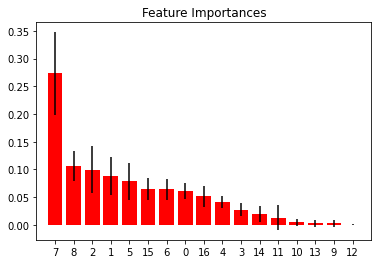

In [475]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

#print the feature ranking
print("Feature ranking: ")
df = pd.DataFrame()
for i,j in zip(x_train_n, forest.feature_importances_):
    aux=pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df=pd.concat([df,aux],axis=0)
    
print(df.sort_values('importance', ascending=False))

#plot the feature ranking
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1,x_train_n.shape[1]])
plt.show()

## 5.3 Hypothesis from EDA

In [476]:
hyp_conclu

,Hypothesis,True/False,Relevance
0,H1 - Fraud should occur in higher value amounts (higher than 200k),True,High
1,H2 - Fraud should occur in higher percent amount per origin balance (higher than 75%),True,High
2,H3 - Fraud should occur in cash_out type of transaction,True,High
3,H4 - Fraud should not occur in debit type of transaction,True,High
4,H5 - Fraud should occur when the difference between old balance and new balance is lower than amount (origin),False,High
5,H6 - Fraud should not occur when the difference between old balance and new balance is equal to amount (origin),False,High
6,H7 - Fraud should not occur when new balance is equal to 0 (origin),False,High
7,H8 - Fraud should occur when the difference between new balance and old balance is lower than amount (destination),False,Low
8,H9 - Fraud should not occur when the difference between new balance and old balance is equal to amount (destination),False,Mid
9,H10 - Fraud should not occur when destination is merchant (destination),True,High


## 5.4 Feature Selection Conclusion

- From Boruta:
    - step
    - amount
    - oldbalance_org
    - newbalance_orig
    - oldbalance_dest
    - newbalance_dest
    - day
    - diff_orig
    - diff_dest
    - hour_sen
    - hour_cos
    - type_TRANSFER
- From Feature Importance:
    - diff_orig
    - oldbalance_org
    - diff_dest
    - amount
    - step 
    - newbalance_dest
    - day
    - hour_sen
    - hour_cos
    - oldbalance_dest
    - newbalance_orig
- From EDA:
    - amount
    - oldbalance_org
    - newbalance_orig
    - diff_orig
    - type
    - day
    - hour
    - merchant_dest

### 5.4.1 Final Feature Selection

In [477]:
 columns_selected = [    
                         'amount', 
                         'oldbalance_org', 
                         'newbalance_orig',
                         'oldbalance_dest', 
                         'newbalance_dest', 
                         'day', 
                         'diff_orig', 
                         'diff_dest',
                         'hour_sen', 
                         'hour_cos', 
                         'type_CASH_IN',
                         'type_CASH_OUT', 
                         'type_DEBIT', 
                         'type_PAYMENT', 
                         'type_TRANSFER'
                    ]
    
x_train = x_train[columns_selected]

x_val = val[columns_selected]
y_val = val['is_fraud'].values

x_validation = val[columns_selected]
y_validation = val['is_fraud'].values

### 5.4.2 Balancing

In [478]:
print('Number of Rows: {}'.format(x_train.shape[0]))

Number of Rows: 863450


In [479]:
y_train.value_counts()

0    858066
1      5384
Name: is_fraud, dtype: int64

In [480]:
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

In [481]:
print('Number of Rows: {}'.format(X_balanced.shape[0]))

Number of Rows: 1716116


In [482]:
y_balanced.value_counts()

0    858058
1    858058
Name: is_fraud, dtype: int64

In [483]:
x_train = X_balanced.copy()
y_train = y_balanced.copy()

# 6.0 Machine Learning Models

## 6.1 Logistic Regression model

In [484]:
logreg_model = LogisticRegression(penalty='l2', solver='newton-cg')

model_reglog = logreg_model.fit(x_train,y_train)

yhat_reglog = model_reglog.predict(x_val)

In [485]:
# model precision
precision_logreg = round(m.precision_score(y_val, yhat_reglog),3)
# recall
recall_logreg = round(m.recall_score(y_val, yhat_reglog),3)
# model accuracy
accuracy_logreg = round(m.accuracy_score(y_val, yhat_reglog),3)
# f1-score
f1_logreg = round(m.f1_score(y_val, yhat_reglog),3)
# mcc
mcc_logreg = round(m.matthews_corrcoef(y_val, yhat_reglog),3)
#Roc_auc
roc_logreg = round(m.roc_auc_score(y_val,yhat_reglog),3)

print("precision: {}" .format(precision_logreg))
print("recall: {}" .format(recall_logreg))
print("accuracy {}".format(accuracy_logreg))
print("f1 {}".format(f1_logreg))
print("mcc {}".format(mcc_logreg))
print("roc {}".format(roc_logreg))

precision: 0.124
recall: 0.948
accuracy 0.958
f1 0.219
mcc 0.335
roc 0.953


In [486]:
m.confusion_matrix(y_val, yhat_reglog)

array([[145052,   6372],
       [    49,    901]], dtype=int64)

In [487]:
models_performance = pd.DataFrame({'Model':['Logistic Regression'], "Precision": [precision_logreg], "Recall": [recall_logreg], "Accuracy": [accuracy_logreg], "F1_Score": [f1_logreg], "Matthews_CorrCoef": [mcc_logreg], "ROC_AUC_Score": [roc_logreg]})

## 6.2 K Neighbors Classifier model

In [488]:
knn_model = KNeighborsClassifier(n_jobs=-1)

model_knn = knn_model.fit(x_train,y_train)

yhat_knn = model_knn.predict(x_val)

In [489]:
# model precision
precision_knn = round(m.precision_score(y_val, yhat_knn),3)
# recall
recall_knn = round(m.recall_score(y_val, yhat_knn),3)
# model accuracy
accuracy_knn = round(m.accuracy_score(y_val, yhat_knn),3)
# f1-score
f1_knn = round(m.f1_score(y_val, yhat_knn),3)
# mcc
mcc_knn = round(m.matthews_corrcoef(y_val, yhat_knn),3)
#Roc_auc
roc_knn = round(m.roc_auc_score(y_val,yhat_knn),3)

print("precision: {}" .format(precision_knn))
print("recall: {}" .format(recall_knn))
print("accuracy {}".format(accuracy_knn))
print("f1 {}".format(f1_knn))
print("mcc {}".format(mcc_knn))
print("roc {}".format(roc_knn))

precision: 0.444
recall: 0.907
accuracy 0.992
f1 0.596
mcc 0.632
roc 0.95


In [490]:
m.confusion_matrix(y_val, yhat_knn)

array([[150344,   1080],
       [    88,    862]], dtype=int64)

In [491]:
models_performance = models_performance.append(pd.Series(['K Neighbors Classifier', precision_knn, recall_knn, accuracy_knn, f1_knn, mcc_knn, roc_knn], index=models_performance.columns), ignore_index=True)

## 6.3 Random Forest Classifier model

In [492]:
rfc_model = RandomForestClassifier(n_estimators=100,random_state=42)

model_rfc = rfc_model.fit(x_train,y_train)

yhat_rfc = model_rfc.predict(x_val)

In [493]:
# model precision
precision_rfc = round(m.precision_score(y_val, yhat_rfc),3)
# recall
recall_rfc = round(m.recall_score(y_val, yhat_rfc),3)
# model accuracy
accuracy_rfc = round(m.accuracy_score(y_val, yhat_rfc),3)
# f1-score
f1_rfc = round(m.f1_score(y_val, yhat_rfc),3)
# mcc
mcc_rfc = round(m.matthews_corrcoef(y_val, yhat_rfc),3)
#Roc_auc
roc_rfc = round(m.roc_auc_score(y_val,yhat_rfc),3)

print("precision: {}" .format(precision_rfc))
print("recall: {}" .format(recall_rfc))
print("accuracy {}".format(accuracy_rfc))
print("f1 {}".format(f1_rfc))
print("mcc {}".format(mcc_rfc))
print("roc {}".format(roc_rfc))

precision: 0.929
recall: 0.935
accuracy 0.999
f1 0.932
mcc 0.931
roc 0.967


In [494]:
m.confusion_matrix(y_val, yhat_rfc)

array([[151356,     68],
       [    62,    888]], dtype=int64)

In [495]:
models_performance = models_performance.append(pd.Series(['Random Forest Classifier', precision_rfc, recall_rfc, accuracy_rfc, f1_rfc, mcc_rfc, roc_rfc], index=models_performance.columns), ignore_index=True)

## 6.4 Naive Bayes Classifier model

In [496]:
nbc_model = GaussianNB()

model_nbc = nbc_model.fit(x_train,y_train)

yhat_nbc = model_nbc.predict(x_val)

In [497]:
# model precision
precision_nbc = round(m.precision_score(y_val, yhat_nbc),3)
# recall
recall_nbc = round(m.recall_score(y_val, yhat_nbc),3)
# model accuracy
accuracy_nbc = round(m.accuracy_score(y_val, yhat_nbc),3)
# f1-score
f1_nbc = round(m.f1_score(y_val, yhat_nbc),3)
# mcc
mcc_nbc = round(m.matthews_corrcoef(y_val, yhat_nbc),3)
#Roc_auc
roc_nbc = round(m.roc_auc_score(y_val,yhat_nbc),3)

print("precision: {}" .format(precision_nbc))
print("recall: {}" .format(recall_nbc))
print("accuracy {}".format(accuracy_nbc))
print("f1 {}".format(f1_nbc))
print("mcc {}".format(mcc_nbc))
print("roc {}".format(roc_nbc))

precision: 0.015
recall: 0.994
accuracy 0.581
f1 0.029
mcc 0.091
roc 0.786


In [498]:
m.confusion_matrix(y_val, yhat_nbc)

array([[87657, 63767],
       [    6,   944]], dtype=int64)

In [499]:
models_performance = models_performance.append(pd.Series(['Naive Bayes Classifier', precision_nbc, recall_nbc, accuracy_nbc, f1_nbc, mcc_nbc, roc_nbc], index=models_performance.columns), ignore_index=True)

## 6.5 Light Gradient Boosting Machine Classifier model

In [500]:
lgbm_model = LGBMClassifier()

model_lgbm = lgbm_model.fit(x_train,y_train)

yhat_lgbm = model_lgbm.predict(x_val)

In [501]:
# model precision
precision_lgbm = round(m.precision_score(y_val, yhat_lgbm),3)
# recall
recall_lgbm = round(m.recall_score(y_val, yhat_lgbm),3)
# model accuracy
accuracy_lgbm = round(m.accuracy_score(y_val, yhat_lgbm),3)
# f1-score
f1_lgbm = round(m.f1_score(y_val, yhat_lgbm),3)
# mcc
mcc_lgbm = round(m.matthews_corrcoef(y_val, yhat_lgbm),3)
#Roc_auc
roc_lgbm = round(m.roc_auc_score(y_val,yhat_lgbm),3)

print("precision: {}" .format(precision_lgbm))
print("recall: {}" .format(recall_lgbm))
print("accuracy {}".format(accuracy_lgbm))
print("f1 {}".format(f1_lgbm))
print("mcc {}".format(mcc_lgbm))
print("roc {}".format(roc_lgbm))

precision: 0.849
recall: 0.935
accuracy 0.999
f1 0.89
mcc 0.89
roc 0.967


In [502]:
m.confusion_matrix(y_val, yhat_lgbm)

array([[151266,    158],
       [    62,    888]], dtype=int64)

In [503]:
models_performance = models_performance.append(pd.Series(['Light GBM Classifier', precision_lgbm, recall_lgbm, accuracy_lgbm, f1_lgbm, mcc_lgbm, roc_lgbm], index=models_performance.columns), ignore_index=True)

## 6.6 XGBoost Classifier model

In [504]:
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)

model_xgb = xgb_model.fit(x_train,y_train)

yhat_xgb = model_xgb.predict(x_val)

In [505]:
# model precision
precision_xgb = round(m.precision_score(y_val, yhat_xgb),3)
# recall
recall_xgb = round(m.recall_score(y_val, yhat_xgb),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_val, yhat_xgb),3)
# f1-score
f1_xgb = round(m.f1_score(y_val, yhat_xgb),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_val, yhat_xgb),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_val,yhat_xgb),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format(recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))

precision: 0.951
recall: 0.932
accuracy 0.999
f1 0.941
mcc 0.941
roc 0.966


In [506]:
m.confusion_matrix(y_val, yhat_xgb)

array([[151378,     46],
       [    65,    885]], dtype=int64)

In [507]:
models_performance = models_performance.append(pd.Series(['XGBoost Classifier', precision_xgb, recall_xgb, accuracy_xgb, f1_xgb, mcc_xgb, roc_xgb], index=models_performance.columns), ignore_index=True)

## 6.7 Final models result

In [508]:
models_performance.sort_values('F1_Score', ascending=False)

,Model,Precision,Recall,Accuracy,F1_Score,Matthews_CorrCoef,ROC_AUC_Score
5,XGBoost Classifier,0.951,0.932,0.999,0.941,0.941,0.966
2,Random Forest Classifier,0.929,0.935,0.999,0.932,0.931,0.967
4,Light GBM Classifier,0.849,0.935,0.999,0.890,0.890,0.967
1,K Neighbors Classifier,0.444,0.907,0.992,0.596,0.632,0.950
0,Logistic Regression,0.124,0.948,0.958,0.219,0.335,0.953
3,Naive Bayes Classifier,0.015,0.994,0.581,0.029,0.091,0.786


## 6.8 Cross Validation

In [509]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision": [], "Recall": [], "Accuracy": [], "F1_Score": [], "Matthews_CorrCoef": [], "ROC_AUC_Score": []})

In [510]:
#models_performance_cv = cross_validation(models_performance_cv, 5 , 'Logistic Regression CV', logreg_model, x_train, y_train)
#models_performance_cv = cross_validation(models_performance_cv, 5 , 'K Neighbors Classifier CV', knn_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest Classifier CV', rfc_model, x_train, y_train)
#models_performance_cv = cross_validation(models_performance_cv, 5 , 'Naive Bayes Classifier CV', nbc_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'LightGBM Classifier CV', lgbm_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier CV', xgb_model, x_train, y_train)

In [511]:
models_per
formance_cv.sort_values('F1_Score', ascending=False)

,Model,Precision,Recall,Accuracy,F1_Score,Matthews_CorrCoef,ROC_AUC_Score
0,Random Forest Classifier CV,0.999 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,0.999 +/- 0.0,1.0 +/- 0.0
2,XGBoost Classifier CV,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,1.0 +/- 0.0,0.999 +/- 0.0,1.0 +/- 0.0
1,LightGBM Classifier CV,0.999 +/- 0.0,0.9992 +/- 0.0004,0.999 +/- 0.0,0.999 +/- 0.0,0.998 +/- 0.0,0.999 +/- 0.0


# 7.0 Hyperparameter tuning

def tune_xgb(params):
    print(params)
    lr                = params[0]
    max_depth         = params[1]
    min_child_weight  = params[2]
    subsample         = params[3]
    colsample_bytree  = params[4]
    n_estimators      = params[5]
    gamma             = params[6]
    reg_lambda        = params[7]
    reg_alpha         = params[8]
    

    #Model
    model = xgb.XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7],reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

    model.fit(x_train, y_train)

    # Model Name
    model_name = type(model).__name__

    # Prediction
    yhat = model.predict(x_val)

    # Prediction Proba
    yhat = model.predict(x_val)
    # Performance
#     model_result = ml_scores(model_name, y_valid, yhat, yhat_proba)
    f1 = m.f1_score(y_val, yhat)
    
    return -f1



param = [(1e-3, 2), #lr
        (1, 20), #max_depth
        (1, 5), #min_child_weight
        (0.05, 1), #subsample
        (0.2, 1), #colsample_bytree
        (10, 150), #n_estimetors
        (1.0, 8.0), #gamma
        (0, 10), #reg_lambda
        (0, 150)]#reg_alpha




result = forest_minimize(tune_xgb, param, random_state=42, n_random_starts=15, n_calls=300, verbose = 1)

result_list_xgb = result.x
result_list_xgb

plot_convergence(result);

## 7.2 Final model - XGBoost Classifier

In [512]:

## Data Description - Rename columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
# rename
dataset_test.columns = cols_new


## Feature engineering
#step features
#hour
dataset_test['hour'] = dataset_test['step'].apply( lambda x: x % 24 )
#day
dataset_test['day'] = dataset_test['step'].apply( lambda x: np.ceil(x / 24) )

#difference between old and new balance origin
dataset_test['diff_orig'] = dataset_test['oldbalance_org'] - dataset_test['newbalance_orig']

#difference between new and old balance destination
dataset_test['diff_dest'] = dataset_test['newbalance_dest'] - dataset_test['oldbalance_dest']

#merchant destination flag
dataset_test['merchant_dest'] = dataset_test.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

In [513]:
#step
dataset_test['step'] = mms_step.transform(dataset_test[['step']].values)

#day
dataset_test['day'] = mms_day.transform(dataset_test[['day']].values)

#amount
dataset_test['amount'] = rbs_amount.transform(dataset_test[['amount']].values)

#oldbalance_org
dataset_test['oldbalance_org'] = obo_amount.transform(dataset_test[['oldbalance_org']].values)

#newbalance_orig 
dataset_test['newbalance_orig'] = nbo_amount.transform(dataset_test[['newbalance_orig']].values)

#oldbalance_dest
dataset_test['oldbalance_dest'] = obd_amount.transform(dataset_test[['oldbalance_dest']].values)

#newbalance_dest
dataset_test['newbalance_dest'] = nbd_amount.transform(dataset_test[['newbalance_dest']].values)

#diff_orig
dataset_test['diff_orig'] = dfo_amount.transform(dataset_test[['diff_orig']].values)

#diff_dest
dataset_test['diff_dest'] = dfd_amount.transform(dataset_test[['diff_dest']].values)

#type
dataset_test = pd.get_dummies(dataset_test, prefix=['type'], columns=['type'])

#hour 
dataset_test['hour_sen'] = dataset_test['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
dataset_test['hour_cos'] = dataset_test['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
dataset_test = dataset_test.drop('hour', axis = 1)

dataset_test = dataset_test.dropna(axis=1).reset_index(drop= True)

In [514]:
x_final = dataset_test[columns_selected]
y_final = dataset_test['is_fraud'].values

In [515]:
params = [0.9117557312257867,
 11,
 1,
 0.9645219938982215,
 0.4564204196559267,
 144,
 1.3008959726002838,
 9,
 1]

model = xgb.XGBClassifier(learning_rate=params[0], num_leaves=2 ** params[1], max_depth=params[1], min_child_weight=params[2],
                                    subsample=params[3], colsample_bytree=params[4], n_estimators=params[5], gamma=params[6], reg_lambda=params[7],reg_alpha=params[8],
                                    booster='gbtree', importance_type='gain', tree_method='exact', bagging_freq=1, random_state=0, n_jobs=-1, verbosity=0)

model.fit(x_train, y_train)

yhat_final_xgb = model_xgb.predict(x_final)

# model precision
precision_xgb = round(m.precision_score(y_final, yhat_final_xgb),3)
# recall
recall_xgb = round(m.recall_score(y_final, yhat_final_xgb),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_final, yhat_final_xgb),3)
# f1-score
f1_xgb = round(m.f1_score(y_final, yhat_final_xgb),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_final, yhat_final_xgb),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_final,yhat_final_xgb),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format
      (recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))

precision: 0.95
recall: 0.928
accuracy 0.999
f1 0.939
mcc 0.939
roc 0.964


In [516]:
yhat_final_xgb = model_xgb.predict(x_final)

In [517]:
# model precision
precision_xgb = round(m.precision_score(y_final, yhat_final_xgb),3)
# recall
recall_xgb = round(m.recall_score(y_final, yhat_final_xgb),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_final, yhat_final_xgb),3)
# f1-score
f1_xgb = round(m.f1_score(y_final, yhat_final_xgb),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_final, yhat_final_xgb),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_final,yhat_final_xgb),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format(recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))

precision: 0.95
recall: 0.928
accuracy 0.999
f1 0.939
mcc 0.939
roc 0.964


In [518]:
m.confusion_matrix(y_final, yhat_final_xgb)

array([[254096,     80],
       [   118,   1525]], dtype=int64)

# 11.0 Dataset Completed

In [ ]:

## Data Description - Rename columns
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
# rename
data_kaggle.columns = cols_new


## Feature engineering
#step features
#hour
data_kaggle['hour'] = data_kaggle['step'].apply( lambda x: x % 24 )
#day
data_kaggle['day'] = data_kaggle['step'].apply( lambda x: np.ceil(x / 24) )

#difference between old and new balance origin
data_kaggle['diff_orig'] = data_kaggle['oldbalance_org'] - data_kaggle['newbalance_orig']

#difference between new and old balance destination
data_kaggle['diff_dest'] = data_kaggle['newbalance_dest'] - data_kaggle['oldbalance_dest']

#merchant destination flag
data_kaggle['merchant_dest'] = data_kaggle.apply(lambda x: 1 if 'M' in x['name_dest'] else 0, axis=1)

In [ ]:
#step
data_kaggle['step'] = mms_step.transform(data_kaggle[['step']].values)

#day
data_kaggle['day'] = mms_day.transform(data_kaggle[['day']].values)

#amount
data_kaggle['amount'] = rbs_amount.transform(data_kaggle[['amount']].values)

#oldbalance_org
data_kaggle['oldbalance_org'] = obo_amount.transform(data_kaggle[['oldbalance_org']].values)

#newbalance_orig 
data_kaggle['newbalance_orig'] = nbo_amount.transform(data_kaggle[['newbalance_orig']].values)

#oldbalance_dest
data_kaggle['oldbalance_dest'] = obd_amount.transform(data_kaggle[['oldbalance_dest']].values)

#newbalance_dest
data_kaggle['newbalance_dest'] = nbd_amount.transform(data_kaggle[['newbalance_dest']].values)

#diff_orig
data_kaggle['diff_orig'] = dfo_amount.transform(data_kaggle[['diff_orig']].values)

#diff_dest
data_kaggle['diff_dest'] = dfd_amount.transform(data_kaggle[['diff_dest']].values)

#type
data_kaggle = pd.get_dummies(data_kaggle, prefix=['type'], columns=['type'])

#hour 
data_kaggle['hour_sen'] = data_kaggle['hour'].apply( lambda x: np.sin( x * (2. * np.pi/24 ) ) )
data_kaggle['hour_cos'] = data_kaggle['hour'].apply( lambda x: np.cos( x * (2. * np.pi/24 ) ) )
data_kaggle = data_kaggle.drop('hour', axis = 1)

data_kaggle = data_kaggle.dropna(axis=1).reset_index(drop= True)

In [ ]:
x_completed = data_kaggle[columns_selected]
y_completed = data_kaggle['is_fraud'].values

In [ ]:
yhat_completed = model_xgb.predict(x_completed)

In [ ]:
# model precision
precision_xgb = round(m.precision_score(y_completed, yhat_completed),3)
# recall
recall_xgb = round(m.recall_score(y_completed, yhat_completed),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_completed, yhat_completed),3)
# f1-score
f1_xgb = round(m.f1_score(y_completed, yhat_completed),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_completed, yhat_completed),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_completed,yhat_completed),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format(recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
#print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))

In [ ]:
m.confusion_matrix(y_completed, yhat_completed)